In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer,
    BartTokenizer,
    BartForConditionalGeneration,
)

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from models.HeadlineGenerationModel import HeadlineGenerationModel
from models.NewsHeadlineDataModule import NewsHeadlineDataModule
from models.BartHeadlineGenerationModel import BartHeadlineGenerationModel

from evaluation.generate_headline import generate_headline
from evaluation.get_topn_words import get_topn_words
from evaluation.evaluate import calculate_scores_df_tuned, calculate_scores_df

In [2]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  PATH = '/content/drive/My Drive/UNI/sem6/NLP/project/articles_bbc.csv'
else:
  PATH = 'data/articles_bbc.csv'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data = pd.read_csv(PATH, index_col=0)
df = data[['Article','Headline']]
print(df.shape)
data.head(10)

(2225, 2)


,Article,Headline,Summary
0,Quarterly profits at US media giant TimeWarner...,Ad sales boost Time Warner profit,TimeWarner said fourth quarter sales rose 2% t...
1,The dollar has hit its highest level against t...,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...
2,The owners of embattled Russian oil giant Yuko...,Yukos unit buyer faces loan claim,Yukos' owner Menatep Group says it will ask Ro...
3,British Airways has blamed high fuel prices fo...,High fuel prices hit BA's profits,"Rod Eddington, BA's chief executive, said the ..."
4,Shares in UK drinks and food firm Allied Domec...,Pernod takeover talk lifts Domecq,Pernod has reduced the debt it took on to fund...
5,Japan's economy teetered on the brink of a tec...,Japan narrowly escapes recession,"On an annual basis, the data suggests annual g..."
6,The US created fewer jobs than expected in Jan...,Jobs growth still slow in the US,The job gains mean that President Bush can cel...
7,"India, which attends the G7 meeting of seven l...",India calls for fair trade rules,At a conference on developing enterprise hoste...
8,Ethiopia produced 14.27 million tonnes of crop...,Ethiopia's crop production up 24%,"In 2003, crop production totalled 11.49 millio..."
9,A US government claim accusing the country's b...,Court rejects $280bn tobacco case,A US government claim accusing the country's b...


In [5]:
train_df, rest_df = train_test_split(df, test_size=0.2)
test_df, val_df = train_test_split(rest_df, test_size=0.5)

train_df.shape, val_df.shape, test_df.shape

((1780, 2), (223, 2), (222, 2))

# T5-small model fine-tuning

In [6]:
tokenizer = T5Tokenizer.from_pretrained('t5-small', model_max_length=512)

In [7]:
article_token_counts, headline_token_counts = [], []

for _, row in train_df.iterrows():
    article_token_count = len(tokenizer.encode(row["Article"]))
    article_token_counts.append(article_token_count)

    headline_token_count = len(tokenizer.encode(row["Headline"]))
    headline_token_counts.append(headline_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'headline text token counts')

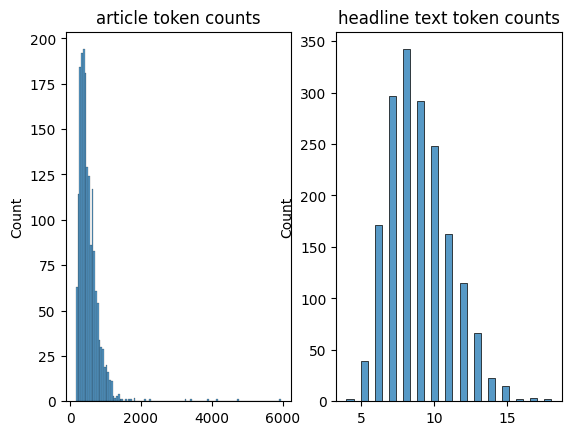

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(article_token_counts, ax=ax1)
ax1.set_title("article token counts")

sns.histplot(headline_token_counts, ax=ax2)
ax2.set_title("headline text token counts")

In [9]:
data_module_t5 = NewsHeadlineDataModule(train_df, val_df, test_df, tokenizer, batch_size=8)

In [10]:
model_t5 = HeadlineGenerationModel("t5-small")

In [11]:
log_path = "logs/t5-small"
checkpoint_path = "checkpoints/t5-small"


checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="best-checkpoint-t5",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger(log_path, name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model_t5, data_module_t5)

# BART fine-tuning

In [12]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base", model_max_length=512)

In [13]:
data_module_bart = NewsHeadlineDataModule(train_df, val_df, test_df, tokenizer, batch_size=8)

In [14]:
model_bart = HeadlineGenerationModel("facebook/bart-base")

In [15]:
log_path = 'logs/bart'
checkpoint_path =  'checkpoints/bart'

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="best-checkpoint-bart",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger(log_path, name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model_bart, data_module_bart)

# Testing

In [6]:
trained_t5 = HeadlineGenerationModel.load_from_checkpoint("checkpoints/t5-small/best-checkpoint-t5.ckpt").model.to(device)
pretrained_t5 = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict=True).to(device)
tokenizer_t5 = T5Tokenizer.from_pretrained('t5-small', model_max_length=512)

trained_bart = BartHeadlineGenerationModel.load_from_checkpoint("checkpoints/bart/best-checkpoint-bart.ckpt").model.to(device)
pretrained_bart = BartForConditionalGeneration.from_pretrained("facebook/bart-base", return_dict=True).to(device)
tokenizer_bart = BartTokenizer.from_pretrained("facebook/bart-base", model_max_length=512)

In [7]:
sample_row = data.iloc[1]
text = sample_row["Article"]
hd = sample_row["Headline"]
summary = sample_row['Summary']

print(len(text.split(" ")))
print(f"True headline: {hd}")

381
True headline: Dollar gains on Greenspan speech


In [9]:
print(f"Tuned T5: {generate_headline(text, tokenizer_t5, trained_t5, max_new_tokens=20)}")
print(f"Pretrained T5: {generate_headline(text, tokenizer_t5, pretrained_t5, prompt='summarize: ')}\n")

print(f"Tuned Bart: {generate_headline(text, tokenizer_bart, trained_bart, max_new_tokens=20)}")
print(f"Pretrained Bart: {generate_headline(text, tokenizer_bart, pretrained_bart, prompt='')}")

Tuned T5: US trade deficit hits greenback
Pretrained T5: in late trading in new york, the dollar reached $1.2871 against the euro. the

Tuned Bart: US trade deficit 'to stabilise'
Pretrained Bart: The dollar has hit its highest level against the euro in almost three months after the Federal Reserve


In [8]:
testing_df = data.sample(100).reset_index()

In [10]:
scores_df = calculate_scores_df(testing_df, tokenizer_t5, pretrained_t5, trained_t5, tokenizer_bart, pretrained_bart, trained_bart, include_summary=True) 

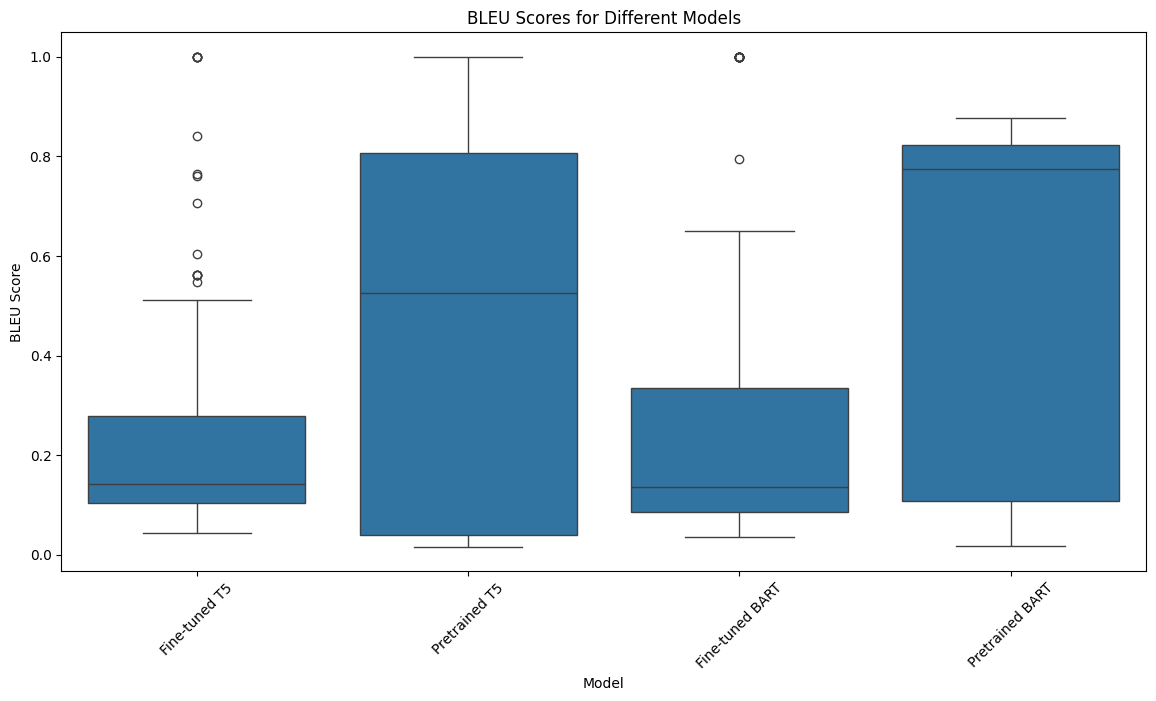

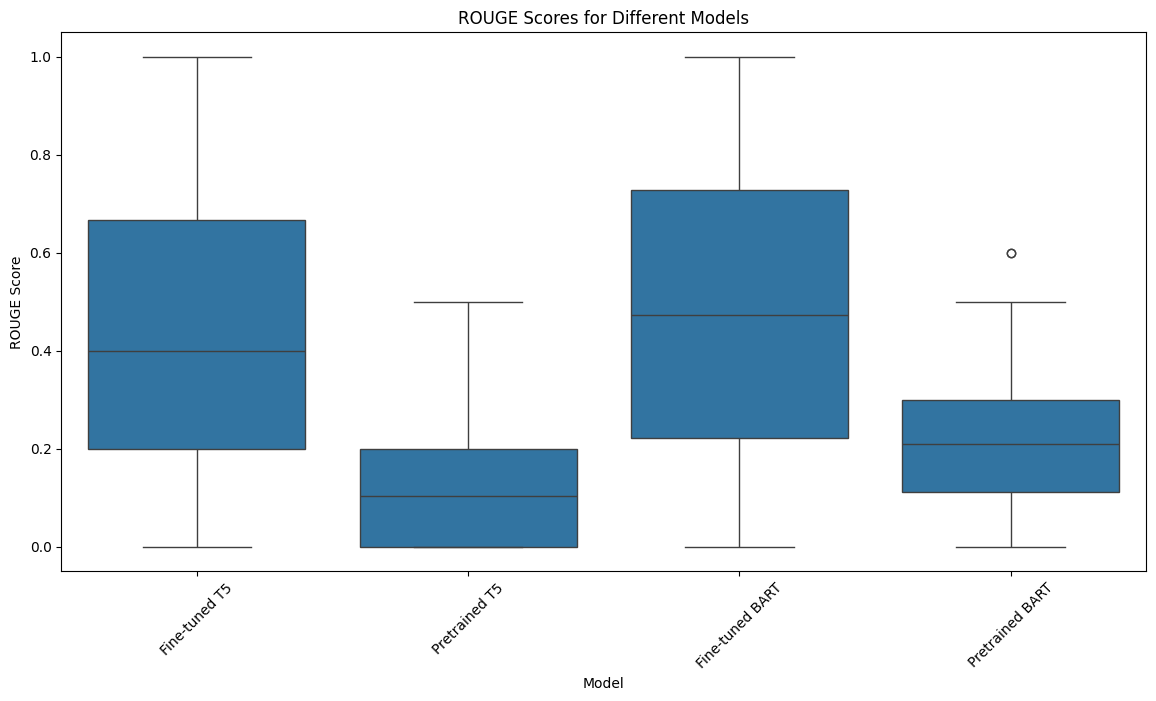

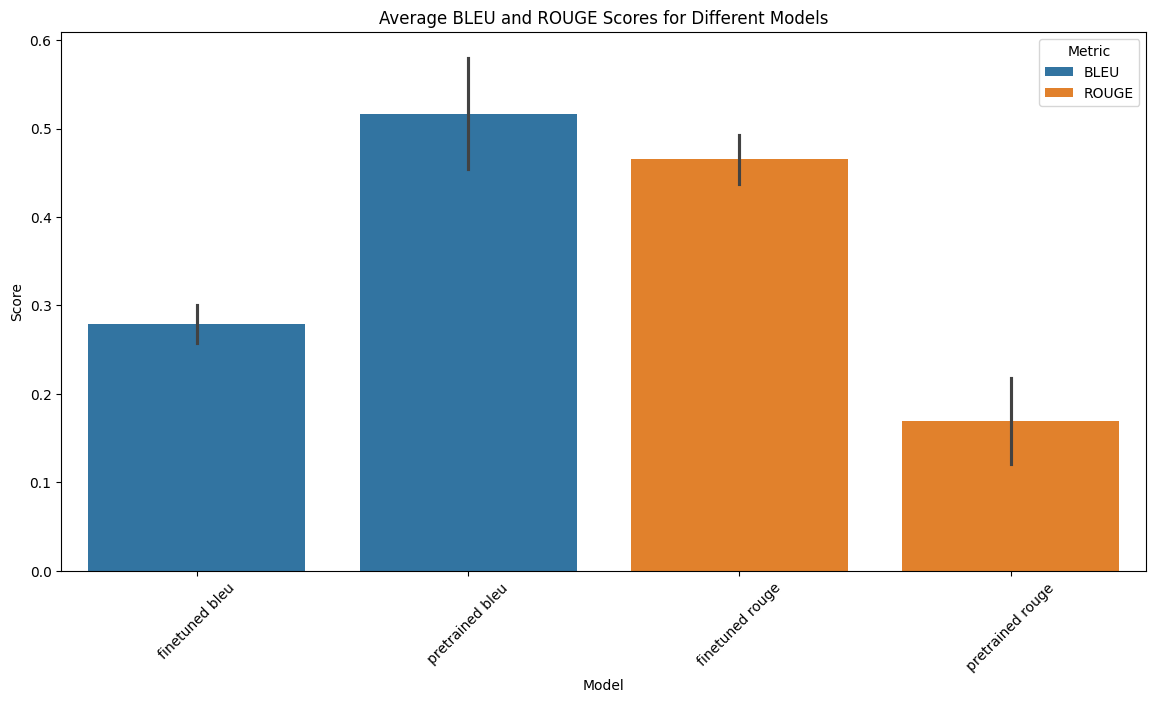

In [11]:
melted_bleu = scores_df.melt(id_vars=['index'], value_vars=['bleu_finetuned_t5', 'bleu_pretrained_t5', 'bleu_finetuned_bart', 'bleu_pretrained_bart'],
                              var_name='Model', value_name='BLEU Score')
melted_rouge = scores_df.melt(id_vars=['index'], value_vars=['rouge_finetuned_t5', 'rouge_pretrained_t5', 'rouge_finetuned_bart', 'rouge_pretrained_bart'],
                               var_name='Model', value_name='ROUGE Score')

model_mapping = {
    'bleu_finetuned_t5': 'Fine-tuned T5',
    'bleu_pretrained_t5': 'Pretrained T5',
    'bleu_finetuned_bart': 'Fine-tuned BART',
    'bleu_pretrained_bart': 'Pretrained BART',
    'rouge_finetuned_t5': 'Fine-tuned T5',
    'rouge_pretrained_t5': 'Pretrained T5',
    'rouge_finetuned_bart': 'Fine-tuned BART',
    'rouge_pretrained_bart': 'Pretrained BART'
}
melted_bleu['Model'] = melted_bleu['Model'].map(model_mapping)
melted_rouge['Model'] = melted_rouge['Model'].map(model_mapping)

plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_bleu, x='Model', y='BLEU Score')
plt.title('BLEU Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_rouge, x='Model', y='ROUGE Score')
plt.title('ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

avg_scores = scores_df[['bleu_finetuned_t5', 'bleu_pretrained_t5', 'bleu_finetuned_bart', 'bleu_pretrained_bart',
                         'rouge_finetuned_t5', 'rouge_pretrained_t5', 'rouge_finetuned_bart', 'rouge_pretrained_bart']].mean()

avg_scores = avg_scores.reset_index()
avg_scores.columns = ['Metric', 'Score']
avg_scores['Model'] = avg_scores['Metric'].apply(lambda x: x.split('_')[1] + ' ' + x.split('_')[0])
avg_scores['Metric'] = avg_scores['Metric'].apply(lambda x: 'BLEU' if 'bleu' in x else 'ROUGE')

plt.figure(figsize=(14, 7))
sns.barplot(data=avg_scores, x='Model', y='Score', hue='Metric')
plt.title('Average BLEU and ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()


# Unseen dataset testing

In [ ]:
unseen_data = pd.read_csv('data/archive/Articles.csv', encoding='cp1252')
unseen_data = unseen_data[['Article', 'Heading']].sample(100).reset_index().drop(columns=['index']).rename(columns={"Heading": "Headline"})
unseen_data

In [ ]:
results_unseen = calculate_scores_df(unseen_data, tokenizer_t5, pretrained_t5, trained_t5, tokenizer_bart, pretrained_bart, trained_bart, include_summary=False, verbose=True)

# Fine-tuned models comparison 